In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rotate
import torch
%autosave 60

Autosaving every 60 seconds


In [2]:
def debug():
    from IPython.core.debugger import Pdb
    Pdb().set_trace()

In [3]:
import cv2
def move_over_y(bar, step=1):
    images = []
    cols = bar.shape[0]
    half_cols = cols //2
    for y in range(-half_cols, half_cols+1 if cols%2==1 else half_cols, step):
        M = np.float32([[1,0,0],[0,1,y]])
        dst = cv2.warpAffine(bar,M,bar.shape)
        images.append(dst)
    return images

In [4]:
def generate_horizontal_bar(size):
    line = cv2.line(np.zeros((size, size), dtype=np.float32),(0,size//2),(size,size//2),1, 1)
    return cv2.GaussianBlur(line, (25, 25), 0)*4

In [5]:
from src.supervised_gcal.utils.math import gaussian
def generate_gaussian(shape, mu_x=0, mu_y=0, sigma_x=None, sigma_y=None):
    return np.fromfunction(function=lambda x, y: gaussian(x, y, mu_x, mu_y, sigma=sigma_x, sigma_y=sigma_y),
                                             shape=shape, dtype=int)

In [6]:
def rotations(img, num=13):
    return dict([(int(degree), [rotate(img, degree, mode='constant').astype(img.dtype)]) for degree in np.linspace(0, 180, num)])

In [7]:
def generate_all_inputs(size):
    vertical_bar = generate_gaussian((size, size), mu_x=48, mu_y=48, sigma_x=6, sigma_y=20)
    move_vertical = move_over_y(vertical_bar)
    inputs = {}
    for degree in np.linspace(0, 180, num=13):
        rotated = []
        for im in move_vertical:
#             mode : {‘constant’, ‘edge’, ‘symmetric’, ‘reflect’, ‘wrap’}
            rot = rotate(im, degree, mode='constant')
            rotated.append(rot.astype(im.dtype))
        inputs[int(degree)] = rotated
    return inputs

In [50]:
keys_arrays = generate_all_inputs(96)

NameError: name 'generate_all_inputs' is not defined

In [8]:
keys_arrays = rotations(generate_gaussian((24, 24), mu_x=12, mu_y=12, sigma_x=1.5, sigma_y=5), num=7)

In [9]:
for k, arrays in keys_arrays.items():
    keys_arrays[k] = list(map(torch.from_numpy, arrays))
gaussians_inputs = [(v, torch.Tensor(k+1)) for k, l in keys_arrays.items() for v in l]

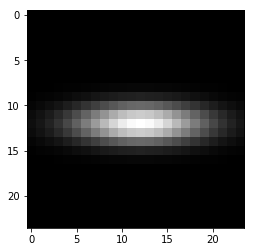

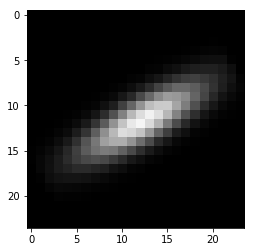

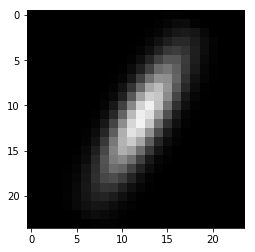

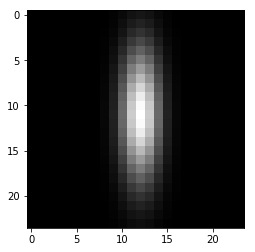

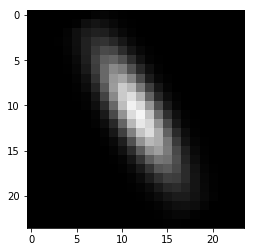

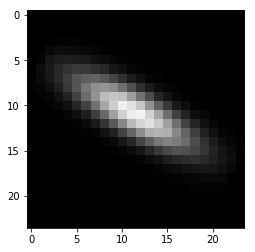

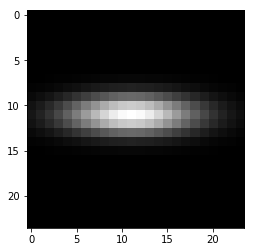

In [89]:
# Shows images
size = 96
for k, im in rotations(generate_gaussian((24, 24), mu_x=12, mu_y=12, sigma_x=1.5, sigma_y=5), num=7).items():
    plt.imshow(im[0], cmap='gray', vmin=0, vmax=1)
    plt.show()

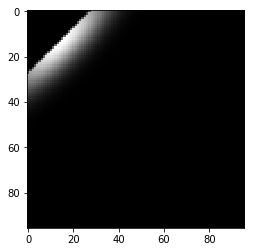

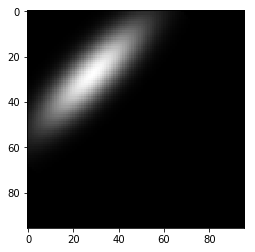

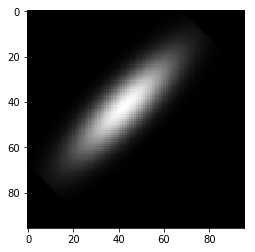

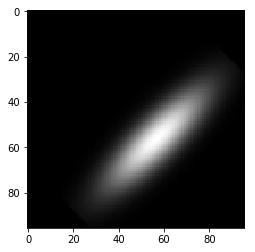

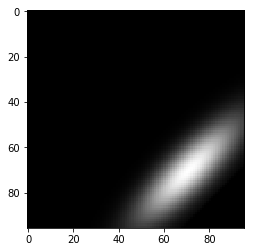

In [47]:
# Shows images
%matplotlib inline
for degree, images in generate_all_inputs(96).items():
    if degree != 45:
        continue
    for idx, im in enumerate(images):
        if idx % 20 == 0:
            plt.imshow(im, cmap='gray', vmin=0, vmax=1)
            plt.show()

In [10]:
from src.supervised_gcal.cortex_layer import CortexLayer
from src.supervised_gcal.optimizers import SequentialOptimizer, SimpleHebbian, NeighborsDecay
input_shape = (24, 24)
cortex_shape = (48, 48)
epochs = 1000
pruning_step = len(gaussians_inputs)
v1_params = {'min_theta':0.1, 'max_theta':0.65, 'afferent_radius':12.96,
                                             'excitatory_radius':4.8, 'inhibitory_radius':10.56, 
                                             'settling_steps':9, 'inhib_factor':0.9, 'excit_factor':0.9}

cortex = CortexLayer(input_shape, cortex_shape, **v1_params)
optimizer = SequentialOptimizer(
                SimpleHebbian(cortex_layer=cortex, learning_rate=0.9590, weight='afferent_weights'),
                SimpleHebbian(cortex_layer=cortex, learning_rate=2.55528, weight='excitatory_weights'),
                SimpleHebbian(cortex_layer=cortex, learning_rate=1.80873, weight='inhibitory_weights'),
                NeighborsDecay(cortex_layer=cortex,
                               pruning_step=pruning_step, final_epoch=epochs))
cortex.cuda()

CortexLayer (
)

In [11]:
lissom = cortex

In [29]:
from src.utils.helpers import save_model
save_model(lissom, optimizer, 'lissom_trained_different_lrs.pth.tar')

In [ ]:
import src.supervised_gcal.utils.images as images
handles = lissom.register_forward_hook(images.generate_images)

In [ ]:
for h in handles:
    h.remove()

In [13]:
from src.utils.pipeline import Pipeline
!jupyter nbextension enable --py --user widgetsnbextension
def maximum_activations(model, inputs):
    activations = []
    for idx, inp in tqdm.tqdm_notebook(enumerate(inputs)):
        inp = torch.autograd.Variable(inp)
        inp = Pipeline._process_input(inp)
        inp = inp.cuda()
        act = model(inp)
        activations.append(act.data)
        if idx % 50 == 0:
            plt.imshow(np.reshape(model.input.data.cpu().numpy(), input_shape), cmap='gray')
            plt.show()
            plt.imshow(np.reshape(act.data.cpu().numpy(), cortex_shape), cmap='gray')
            plt.show()
#         act = torch.from_numpy(act.data)
    maximums, indices = torch.max(torch.stack(activations), 0)
    return maximums

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [14]:
def calculate_keys_activations(model, inputs):
    activations = {}
    for k, images in inputs.items():
        print('Calculating key {} activations'.format(k))
        activations[k] = maximum_activations(model, images)
    return activations

In [17]:
from src.utils.pipeline import Pipeline
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(gaussians_inputs, shuffle=True, pin_memory=True)
pipe = Pipeline(lissom, optimizer, cuda=True, log_interval=len(gaussians_inputs)-1)

In [18]:
from tqdm._tqdm import mp, th
import tqdm
import tqdm._tqdm_notebook
tqdm._tqdm_notebook.tqdm_notebook._lock.locks[0]= mp.Lock()
tqdm._tqdm_notebook.tqdm_notebook._lock.locks[1] = th.Lock()

In [19]:
for epoch in tqdm.tqdm_notebook(range(epochs)):
    pipe.train(train_loader, epoch)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Train Epoch: 0 Iterations: 0%
Train Epoch: 0 Iterations: 86%
Train Epoch: 1 Iterations: 0%
Train Epoch: 1 Iterations: 86%
Train Epoch: 2 Iterations: 0%
Train Epoch: 2 Iterations: 86%
Train Epoch: 3 Iterations: 0%
Train Epoch: 3 Iterations: 86%
Train Epoch: 4 Iterations: 0%
Train Epoch: 4 Iterations: 86%
Train Epoch: 5 Iterations: 0%
Train Epoch: 5 Iterations: 86%
Train Epoch: 6 Iterations: 0%
Train Epoch: 6 Iterations: 86%
Train Epoch: 7 Iterations: 0%
Train Epoch: 7 Iterations: 86%
Train Epoch: 8 Iterations: 0%
Train Epoch: 8 Iterations: 86%
Train Epoch: 9 Iterations: 0%
Train Epoch: 9 Iterations: 86%
Train Epoch: 10 Iterations: 0%
Train Epoch: 10 Iterations: 86%
Train Epoch: 11 Iterations: 0%
Train Epoch: 11 Iterations: 86%
Train Epoch: 12 Iterations: 0%
Train Epoch: 12 Iterations: 86%
Train Epoch: 13 Iterations: 0%
Train Epoch: 13 Iterations: 86%
Train Epoch: 14 Iterations: 0%
Train Epoch: 14 Iterations: 86%
Train Epoch: 15 Iterations: 0%
Train Epoch: 15 Iterations: 86%
Train Epoch:

Train Epoch: 129 Iterations: 86%
Train Epoch: 130 Iterations: 0%
Train Epoch: 130 Iterations: 86%
Train Epoch: 131 Iterations: 0%
Train Epoch: 131 Iterations: 86%
Train Epoch: 132 Iterations: 0%
Train Epoch: 132 Iterations: 86%
Train Epoch: 133 Iterations: 0%
Train Epoch: 133 Iterations: 86%
Train Epoch: 134 Iterations: 0%
Train Epoch: 134 Iterations: 86%
Train Epoch: 135 Iterations: 0%
Train Epoch: 135 Iterations: 86%
Train Epoch: 136 Iterations: 0%
Train Epoch: 136 Iterations: 86%
Train Epoch: 137 Iterations: 0%
Train Epoch: 137 Iterations: 86%
Train Epoch: 138 Iterations: 0%
Train Epoch: 138 Iterations: 86%
Train Epoch: 139 Iterations: 0%
Train Epoch: 139 Iterations: 86%
Train Epoch: 140 Iterations: 0%
Train Epoch: 140 Iterations: 86%
Train Epoch: 141 Iterations: 0%
Train Epoch: 141 Iterations: 86%
Train Epoch: 142 Iterations: 0%
Train Epoch: 142 Iterations: 86%
Train Epoch: 143 Iterations: 0%
Train Epoch: 143 Iterations: 86%
Train Epoch: 144 Iterations: 0%
Train Epoch: 144 Iteratio

Train Epoch: 256 Iterations: 86%
Train Epoch: 257 Iterations: 0%
Train Epoch: 257 Iterations: 86%
Train Epoch: 258 Iterations: 0%
Train Epoch: 258 Iterations: 86%
Train Epoch: 259 Iterations: 0%
Train Epoch: 259 Iterations: 86%
Train Epoch: 260 Iterations: 0%
Train Epoch: 260 Iterations: 86%
Train Epoch: 261 Iterations: 0%
Train Epoch: 261 Iterations: 86%
Train Epoch: 262 Iterations: 0%
Train Epoch: 262 Iterations: 86%
Train Epoch: 263 Iterations: 0%
Train Epoch: 263 Iterations: 86%
Train Epoch: 264 Iterations: 0%
Train Epoch: 264 Iterations: 86%
Train Epoch: 265 Iterations: 0%
Train Epoch: 265 Iterations: 86%
Train Epoch: 266 Iterations: 0%
Train Epoch: 266 Iterations: 86%
Train Epoch: 267 Iterations: 0%
Train Epoch: 267 Iterations: 86%
Train Epoch: 268 Iterations: 0%
Train Epoch: 268 Iterations: 86%
Train Epoch: 269 Iterations: 0%
Train Epoch: 269 Iterations: 86%
Train Epoch: 270 Iterations: 0%
Train Epoch: 270 Iterations: 86%
Train Epoch: 271 Iterations: 0%
Train Epoch: 271 Iteratio

Train Epoch: 383 Iterations: 86%
Train Epoch: 384 Iterations: 0%
Train Epoch: 384 Iterations: 86%
Train Epoch: 385 Iterations: 0%
Train Epoch: 385 Iterations: 86%
Train Epoch: 386 Iterations: 0%
Train Epoch: 386 Iterations: 86%
Train Epoch: 387 Iterations: 0%
Train Epoch: 387 Iterations: 86%
Train Epoch: 388 Iterations: 0%
Train Epoch: 388 Iterations: 86%
Train Epoch: 389 Iterations: 0%
Train Epoch: 389 Iterations: 86%
Train Epoch: 390 Iterations: 0%
Train Epoch: 390 Iterations: 86%
Train Epoch: 391 Iterations: 0%
Train Epoch: 391 Iterations: 86%
Train Epoch: 392 Iterations: 0%
Train Epoch: 392 Iterations: 86%
Train Epoch: 393 Iterations: 0%
Train Epoch: 393 Iterations: 86%
Train Epoch: 394 Iterations: 0%
Train Epoch: 394 Iterations: 86%
Train Epoch: 395 Iterations: 0%
Train Epoch: 395 Iterations: 86%
Train Epoch: 396 Iterations: 0%
Train Epoch: 396 Iterations: 86%
Train Epoch: 397 Iterations: 0%
Train Epoch: 397 Iterations: 86%
Train Epoch: 398 Iterations: 0%
Train Epoch: 398 Iteratio

Train Epoch: 510 Iterations: 86%
Train Epoch: 511 Iterations: 0%
Train Epoch: 511 Iterations: 86%
Train Epoch: 512 Iterations: 0%
Train Epoch: 512 Iterations: 86%
Train Epoch: 513 Iterations: 0%
Train Epoch: 513 Iterations: 86%
Train Epoch: 514 Iterations: 0%
Train Epoch: 514 Iterations: 86%
Train Epoch: 515 Iterations: 0%
Train Epoch: 515 Iterations: 86%
Train Epoch: 516 Iterations: 0%
Train Epoch: 516 Iterations: 86%
Train Epoch: 517 Iterations: 0%
Train Epoch: 517 Iterations: 86%
Train Epoch: 518 Iterations: 0%
Train Epoch: 518 Iterations: 86%
Train Epoch: 519 Iterations: 0%
Train Epoch: 519 Iterations: 86%
Train Epoch: 520 Iterations: 0%
Train Epoch: 520 Iterations: 86%
Train Epoch: 521 Iterations: 0%
Train Epoch: 521 Iterations: 86%
Train Epoch: 522 Iterations: 0%
Train Epoch: 522 Iterations: 86%
Train Epoch: 523 Iterations: 0%
Train Epoch: 523 Iterations: 86%
Train Epoch: 524 Iterations: 0%
Train Epoch: 524 Iterations: 86%
Train Epoch: 525 Iterations: 0%
Train Epoch: 525 Iteratio

Train Epoch: 637 Iterations: 86%
Train Epoch: 638 Iterations: 0%
Train Epoch: 638 Iterations: 86%
Train Epoch: 639 Iterations: 0%
Train Epoch: 639 Iterations: 86%
Train Epoch: 640 Iterations: 0%
Train Epoch: 640 Iterations: 86%
Train Epoch: 641 Iterations: 0%
Train Epoch: 641 Iterations: 86%
Train Epoch: 642 Iterations: 0%
Train Epoch: 642 Iterations: 86%
Train Epoch: 643 Iterations: 0%
Train Epoch: 643 Iterations: 86%
Train Epoch: 644 Iterations: 0%
Train Epoch: 644 Iterations: 86%
Train Epoch: 645 Iterations: 0%
Train Epoch: 645 Iterations: 86%
Train Epoch: 646 Iterations: 0%
Train Epoch: 646 Iterations: 86%
Train Epoch: 647 Iterations: 0%
Train Epoch: 647 Iterations: 86%
Train Epoch: 648 Iterations: 0%
Train Epoch: 648 Iterations: 86%
Train Epoch: 649 Iterations: 0%
Train Epoch: 649 Iterations: 86%
Train Epoch: 650 Iterations: 0%
Train Epoch: 650 Iterations: 86%
Train Epoch: 651 Iterations: 0%
Train Epoch: 651 Iterations: 86%
Train Epoch: 652 Iterations: 0%
Train Epoch: 652 Iteratio

Train Epoch: 764 Iterations: 86%
Train Epoch: 765 Iterations: 0%
Train Epoch: 765 Iterations: 86%
Train Epoch: 766 Iterations: 0%
Train Epoch: 766 Iterations: 86%
Train Epoch: 767 Iterations: 0%
Train Epoch: 767 Iterations: 86%
Train Epoch: 768 Iterations: 0%
Train Epoch: 768 Iterations: 86%
Train Epoch: 769 Iterations: 0%
Train Epoch: 769 Iterations: 86%
Train Epoch: 770 Iterations: 0%
Train Epoch: 770 Iterations: 86%
Train Epoch: 771 Iterations: 0%
Train Epoch: 771 Iterations: 86%
Train Epoch: 772 Iterations: 0%
Train Epoch: 772 Iterations: 86%
Train Epoch: 773 Iterations: 0%
Train Epoch: 773 Iterations: 86%
Train Epoch: 774 Iterations: 0%
Train Epoch: 774 Iterations: 86%
Train Epoch: 775 Iterations: 0%
Train Epoch: 775 Iterations: 86%
Train Epoch: 776 Iterations: 0%
Train Epoch: 776 Iterations: 86%
Train Epoch: 777 Iterations: 0%
Train Epoch: 777 Iterations: 86%
Train Epoch: 778 Iterations: 0%
Train Epoch: 778 Iterations: 86%
Train Epoch: 779 Iterations: 0%
Train Epoch: 779 Iteratio

Train Epoch: 891 Iterations: 86%
Train Epoch: 892 Iterations: 0%
Train Epoch: 892 Iterations: 86%
Train Epoch: 893 Iterations: 0%
Train Epoch: 893 Iterations: 86%
Train Epoch: 894 Iterations: 0%
Train Epoch: 894 Iterations: 86%
Train Epoch: 895 Iterations: 0%
Train Epoch: 895 Iterations: 86%
Train Epoch: 896 Iterations: 0%
Train Epoch: 896 Iterations: 86%
Train Epoch: 897 Iterations: 0%
Train Epoch: 897 Iterations: 86%
Train Epoch: 898 Iterations: 0%
Train Epoch: 898 Iterations: 86%
Train Epoch: 899 Iterations: 0%
Train Epoch: 899 Iterations: 86%
Train Epoch: 900 Iterations: 0%
Train Epoch: 900 Iterations: 86%
Train Epoch: 901 Iterations: 0%
Train Epoch: 901 Iterations: 86%
Train Epoch: 902 Iterations: 0%
Train Epoch: 902 Iterations: 86%
Train Epoch: 903 Iterations: 0%
Train Epoch: 903 Iterations: 86%
Train Epoch: 904 Iterations: 0%
Train Epoch: 904 Iterations: 86%
Train Epoch: 905 Iterations: 0%
Train Epoch: 905 Iterations: 86%
Train Epoch: 906 Iterations: 0%
Train Epoch: 906 Iteratio

OSError: [Errno 24] Too many open files: 'runs/train/epoch_0/events.out.tfevents.1507394670.nikola'

In [ ]:
lissom.epoch

In [ ]:
%matplotlib inline
import shutil
import os 
if os.path.exists('runs'):
    shutil.rmtree('runs')
activations = calculate_keys_activations(lissom, keys_arrays)

In [ ]:
%matplotlib inline
for k, im in activations.items():
    plt.imshow(np.reshape(im.cpu().numpy(), cortex_shape), cmap='gray', vmin=0, vmax=1)
    plt.show()

In [ ]:
def orientation_map(activations):
    mat = torch.stack(list(activations.values()))
    values, preferences = torch.max(mat, 0)
    keys = list(activations.keys())
    orientation_map = []
    for idx in preferences[0]:
        orientation_map.append(keys[idx])
    return np.reshape(np.asarray(orientation_map), cortex_shape)

In [ ]:
orientation_map = orientation_map(activations)

In [ ]:
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.imshow(orientation_map, cmap='tab20')
plt.colorbar()

In [ ]:
from collections import defaultdict
orientation_hist = defaultdict(int)
for key in np.nditer(orientation_map):
    orientation_hist[int(key)] += 1

In [ ]:
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.pie([float(v) for v in orientation_hist.values()], labels=[float(k) for k in orientation_hist.keys()],
           autopct=None)
plt.show()